# Change Detection with DEMs

In [1]:
from pathlib import Path

# Define some path constants for use later in the exercise
NOTEBOOK_DIR = Path(__name__).resolve().parent
DATA_DIR = NOTEBOOK_DIR / "data"

## Study Area

This exercise will look at the change to Columbia Glacier, AK, USA using ArcticDEM strips. 

Columbia Glacier is "one of the most rapidly changing glaciers in the world." [[NASA Earth Observatory](https://earthobservatory.nasa.gov/world-of-change/ColumbiaGlacier)]. The rapid retreat of the glacier's terminus will allow us to demonstrate an obvious change within our strip DEM archive spanning a little more than a decade.

A GeoJson file (`aoi.geojson`) delineating the Area of interest has been provided alongside this notebook. In this section, we will load this in an interactive map and familiarize ourselves with the area.

In [2]:
import geopandas as gpd

AOI_GEOJSON = NOTEBOOK_DIR / "aoi.geojson"

# Load the AOI as a GeoDataFrame
aoi: gpd.GeoDataFrame = gpd.read_file(AOI_GEOJSON)

In [3]:
# Check out the content of the aoi
print(f"CRS: {aoi.crs}")
print("Content:")
print(aoi.head())

CRS: EPSG:4326
Content:
               name                                           geometry
0  Area of Interest  POLYGON ((-147.07638 61.11004, -147.27669 61.0...


In [4]:
import leafmap


def initialize_default_interactive_map() -> leafmap.Map:
    """Returns a leafmap.Map object with common UI elements preconfigured. Use within
    the body of specific interactive map functions to initialize the Map object."""

    # Initialize a default Map
    m = leafmap.Map()

    # Add helpful GUI elements to the map interface
    m.add_gui(name="layer_manager", position="topright", opened=False)

    return m

In [5]:
from pathlib import Path
import leafmap


def create_interactive_aoi_map(aoi_geojson: Path) -> leafmap.Map:
    """Returns an interactive map loaded with basemaps and the provided AOI loaded from a geojson file."""

    m = initialize_default_interactive_map()

    # Add data to the map. Each call to m.add_<something> places that data on the top of
    # the visual hierarchy. Therefore we will generally want to add basemaps first, rasters
    # second, and vectors last.

    # Add relevant basemaps
    m.add_basemap("Esri.WorldImagery", show=True)
    m.add_basemap("USGS.USImagery", show=False)

    # No raster data yet

    # Add vector data
    m.add_geojson(str(aoi_geojson), layer_name="Area of Interest", zoom_to_layer=True)

    return m

The next cell uses the map functions defined above to create an interactive map of our study area. 

The basemap that is initially visible is `ESRI WorldImagery`. Zoom in and out around the AOI. Newer images are used at the closer zoom levels, which allows us to see a significant change in the location of the glacier terminus.

A second basemap, `USGS.USImagery`, is attached as well. Use the **Layer Manager** in the top right of the map to toggle its visibility. This basemap uses even older imagery, which shows an even larger change of the glacier terminus.

In [6]:
interactive_map = create_interactive_aoi_map(AOI_GEOJSON)
interactive_map

Map(center=[20, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

## Finding Strip DEMs

In this section, we will search the ArcticDEM strip DEM archive for DEMs we can use to show and quantify the change to this glacier.

The heavy-lifting is accomplished using Thomas Chudley's `pDEMtools` library. [[Repo](https://github.com/trchudley/pdemtools)] [[Docs](https://pdemtools.readthedocs.io/)] This library provides STAC-like search and loading functionality for PGC DEM products.

The following 3 cells define and execute functions to download a parquet of the ArcticDEM strip index. 

The strip index is also available as a Shapefile, FileGeoDatabase, or GeoPackage. Links for each can be found on the [PGC ArcticDEM Webpage](https://www.pgc.umn.edu/data/arcticdem/).

In [7]:
from pathlib import Path
import requests


def download_strip_index_archive(url: str, output_dir: Path) -> Path:
    """Downloads the zipped strip index to the provided output directory and returns a
    path to the downloaded file."""

    # Make sure the output directory exists
    if not output_dir.exists():
        output_dir.mkdir(parents=True)

    # Download the zip archive to the output directory
    r = requests.get(url, stream=True)

    # Throw an Exception if the request returned an error status
    r.raise_for_status()

    # Write the archive to the filesystem
    archive = output_dir / "strip_index_archive.zip"
    with open(archive, "wb") as f:
        for chunk in r.iter_content(chunk_size=128):
            f.write(chunk)

    return archive

In [8]:
import shutil


def unzip_strip_index_archive(archive: Path) -> Path:
    """Unzips the content of an archive into the same directory as the archive."""

    shutil.unpack_archive(filename=archive, extract_dir=archive.parent)

The following cell downloads strip archive. The archive is about 320 MB, so the cell may several seconds to a few minutes to complete depending on your connection speed.

In [9]:
STRIP_INDEX_ARCHIVE_URL = "https://data.pgc.umn.edu/elev/dem/setsm/ArcticDEM/indexes/ArcticDEM_Strip_Index_latest_gpqt.zip"
STRIP_DIR = DATA_DIR / "strips"

# Download the strip index archive to a subfolder in the data directory
strip_index_archive = download_strip_index_archive(
    url=STRIP_INDEX_ARCHIVE_URL, output_dir=STRIP_DIR
)

In [10]:
# Unzip the archive
unzip_strip_index_archive(archive=strip_index_archive)

The next few cells search the strip index for any strip that overlaps at least 90% of our AOI. 

In [11]:
from pathlib import Path

import pdemtools as pdt
from shapely import Polygon


def get_intersecting_strips(
    strip_index: Path, bounds: Polygon, min_aoi_frac: float
) -> gpd.GeoDataFrame:
    """Wrapper around the search functionality in pdemtools. Returns a GeoDataFrame of matching
    strips sorted by acquisition date."""

    strips: gpd.GeoDataFrame = pdt.search(
        index_fpath=str(strip_index),
        bounds=bounds,
        min_aoi_frac=min_aoi_frac,
    )

    return strips.sort_values("acqdate1")

In [12]:
# The name of the unzipped strip index will change with new versions of ArcticDEM
# Rather than hardcoding the name here, we will search for the parquet file that
# was unzipped.
STRIP_INDEX = list(STRIP_DIR.glob("*/*.parquet"))[0]

# The geometries in the ArcticDEM strip index are in EPSG:3413, but our aoi is in
# EPSG:4326. We need to reproject the geometry before using it as our search bounds.
bounds: Polygon = aoi.to_crs("EPSG:3413").iloc[0].geometry

# Define the minimum overlap percentage between our AOI and any strip DEM.
# Higher percentages will (usually) result in fewer matches.
min_aoi_frac = 0.90

strips = get_intersecting_strips(
    strip_index=STRIP_INDEX, bounds=bounds, min_aoi_frac=min_aoi_frac
)
print(f"Found {strips.shape[0]} strips matching the search criteria")

Found 28 strips matching the search criteria


In [13]:
# Look at the first 5 rows of the matching strips
strips.head()

fid                                             dem_id  \
375797  375798  SETSM_s2s041_GE01_20120616_1050410000CCCE00_10...   
375815  375816  SETSM_s2s041_GE01_20120813_1050410000829A00_10...   
375788  375789  SETSM_s2s041_GE01_20121012_1050410000283800_10...   
375722  375723  SETSM_s2s041_WV01_20130610_1020010020861300_10...   
375799  375800  SETSM_s2s041_WV02_20130712_103001002578FB00_10...   

                                               pairname  \
375797  GE01_20120616_1050410000CCCE00_1050410000CAD600   
375815  GE01_20120813_1050410000829A00_1050410000759100   
375788  GE01_20121012_1050410000283800_105041000027B200   
375722  WV01_20130610_1020010020861300_1020010024444C00   
375799  WV02_20130712_103001002578FB00_1030010024C0FD00   

                                               stripdemid sensor1 sensor2  \
375797  GE01_20120616_1050410000CCCE00_1050410000CAD60...    GE01    GE01   
375815  GE01_20120813_1050410000829A00_105041000075910...    GE01    GE01   
375788  GE01_20121012_1050410000283800_105041000027B20...    GE01    GE01   
375722  WV01_20130610_1020010020861300_1020010024444C0...    WV01    WV01   
375799  WV02_20130712_103001002578FB00_1030010024C0FD0...    WV02    WV02   

              catalogid1        catalogid2            acqdate1  \
375797  1050410000CCCE00  1050410000CAD600 2012-06-16 20:51:00   
375815  1050410000829A00  1050410000759100 2012-08-13 21:03:40   
375788  1050410000283800  105041000027B200 2012-10-12 20:49:32   
375722  1020010020861300  1020010024444C00 2013-06-10 21:20:08   
375799  103001002578FB00  1030010024C0FD00 2013-07-12 22:04:24   

                  acqdate2  ...  cloud_area_sqkm  cloud_area_percent  \
375797 2012-06-16 20:50:05  ...       190.363244            0.422274   
375815 2012-08-13 21:02:51  ...        48.151820            0.127937   
375788 2012-10-12 20:48:38  ...        77.422264            0.168067   
375722 2013-06-10 21:20:53  ...       107.061772            0.172530   
375799 2013-07-12 22:03:24  ...        84.499264            0.136048   

       avg_convergence_angle avg_expected_height_accuracy avg_sun_elev1  \
375797          -9999.000000                 -9999.000000     51.066667   
375815          -9999.000000                 -9999.000000     42.466667   
375788          -9999.000000                 -9999.000000     20.666667   
375722             36.385234                     1.075711     51.800000   
375799             30.387618                     1.301678     50.830001   

       avg_sun_elev2      rmse  \
375797     51.000000  1.890100   
375815     42.433333  1.099500   
375788     20.633333  1.282000   
375722     51.830001  0.628011   
375799     50.870000  0.791388   

                                                  fileurl  \
375797  https://data.pgc.umn.edu/elev/dem/setsm/Arctic...   
375815  https://data.pgc.umn.edu/elev/dem/setsm/Arctic...   
375788  https://data.pgc.umn.edu/elev/dem/setsm/Arctic...   
375722  https://data.pgc.umn.edu/elev/dem/setsm/Arctic...   
375799  https://data.pgc.umn.edu/elev/dem/setsm/Arctic...   

                                                    s3url  \
375797  https://polargeospatialcenter.github.io/stac-b...   
375815  https://polargeospatialcenter.github.io/stac-b...   
375788  https://polargeospatialcenter.github.io/stac-b...   
375722  https://polargeospatialcenter.github.io/stac-b...   
375799  https://polargeospatialcenter.github.io/stac-b...   

                                                     geom  
375797  POLYGON ((-3112793.238 679439.148, -3112793.23...  
375815  POLYGON ((-3114586.000 679052.000, -3112793.23...  
375788  POLYGON ((-3124224.238 679859.654, -3112793.23...  
375722  POLYGON ((-3112793.238 678400.589, -3112793.23...  
375799  POLYGON ((-3114324.000 679188.000, -3112793.23...  

[5 rows x 33 columns]

Next, we will look at previews of the DEMs to select two to carry forward in our analysis. 

The background of the figures is set to a light purple to make it easy to identify areas of NoData/Bad pixels. Some of the previews will also show read outlines. These are the edge of the strip DEM.

In [14]:
import matplotlib.pyplot as plt


def preview_strip(strips: gpd.GeoDataFrame, bounds: Polygon, index: int) -> plt.Figure:
    """Construct a figure for the row matching the provided index."""

    # Extract the row of interest as a one-row GeoDataFrame
    row = strips.iloc[[index]]

    # Load the remote preview image, limited to the provided bounds
    preview = pdt.load.preview(row, bounds)

    # Close any pervious plt objects hanging around in memory
    plt.close("all")

    # Build the figure
    fig, ax = plt.subplots(layout="constrained")
    ax.set_facecolor("plum")
    preview.plot(cmap="Greys_r", add_colorbar=False)
    row.plot(ax=ax, fc="none", ec="tab:red")
    ax.set_title(f"index: {index}, date: {row.acqdate1.dt.date.values[0]}")

    return fig

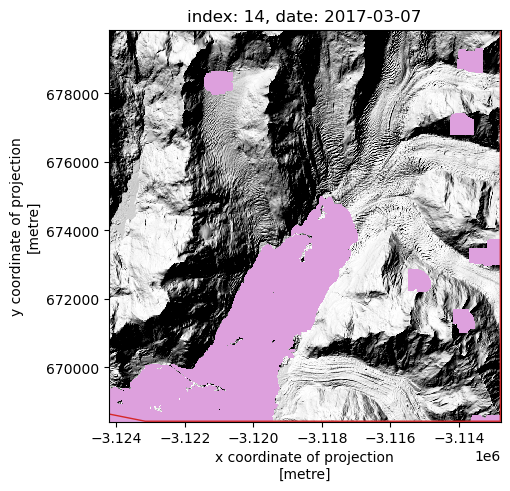

In [15]:
# Look at one of the strip preview figures
f = preview_strip(strips, bounds, 14)

It would be annoying to look at more than a few figures within this notebook itself. Instead, the next cell creates a figure for each strip returned by the search and saves that figure as a `.png` file to the `strip_preview` subdirectory of the data directory.

Each figure takes a few seconds to create, so the cell may take a minute or more to complete.

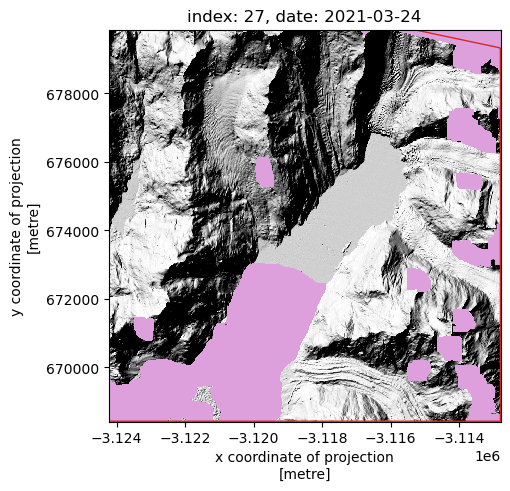

In [16]:
STRIP_PREVIEWS_DIR = DATA_DIR / "strip_previews"

# Make sure the output directory exists
if not STRIP_PREVIEWS_DIR.exists():
    STRIP_PREVIEWS_DIR.mkdir(parents=True)

# Create and save a figure for each row in strips
# The figures are named by the acquire date
for index in range(strips.shape[0]):
    # Extract the acquire date as a YYYY-MM-DD string
    title = strips.iloc[[index]].acqdate1.dt.date.values[0]

    # Define the output file path
    filepath = STRIP_PREVIEWS_DIR / f"{title}.png"

    # Create and save the figure, if it doesn't already exist
    if not filepath.exists():
        f = preview_strip(strips, bounds, index)
        f.savefig(filepath, format="png")

After inspecting the strip previews, we will select the strips for dates 2012-08-13 (`index: 1`) and 2018-04-16 (`index: 21`) for use in our change detection analysis. These strips have minimal data gaps in the glacier itself and the stable ground areas we will need to coregister the images.

In [17]:
from pathlib import Path
import geopandas as gpd
from shapely import Polygon


def download_strip(row: gpd.GeoDataFrame, bounds: Polygon, output_dir: Path):
    """Downloads a clipped strip DEM for the provided search results row named by its acquistion
    Returns the path to the downloaded strip."""

    # Make sure the output directory exists
    if not output_dir.exists():
        output_dir.mkdir(parents=True)

    # Construct the output filepath
    filename = f"{row.acqdate1.dt.date.values[0]}.tif"
    filepath = output_dir / filename

    # Load the relevant portion of the strip DEM
    dem = pdt.load.from_search(row, bounds, bitmask=True)

    # Write the clipped strip to the file system
    dem.rio.to_raster(filepath)

    return filepath

In [18]:
# Build a list of single row GeoDataFrames for two selected images
selected_rows = [
    strips.iloc[[1]],  # Row corresponding to 2012-08-13
    strips.iloc[[21]],  # Row corresponding to 2018-04-16
]

The following cell downloads the selected strips. This will take several seconds to a few minutes, depending on the number of strips selected and the speed of your connection.

In [19]:
# Download the strips defined in the selected rows list to the strip directory
for row in selected_rows:
    download_strip(row, bounds, STRIP_DIR)

## Backgound Data

Before we can preform analysis on the strip DEMs we downloaded, we will want to coregister them to a common reference DEM. To facilitate the coregistration, we will need both the reference DEM itself and a land-use raster for identifying stable ground.

We will use the [data catalog](https://planetarycomputer.microsoft.com/catalog) hosted for Microsoft's [Planetary Computer](https://planetarycomputer.microsoft.com/) and its STAC API to discover and download these data. 

In [20]:
from dataclasses import dataclass

import pystac


@dataclass(frozen=True)
class PCCollectionInfo:
    """Data container for storing relevant metadata for using assets in MicroSoft's Planetary Computer STAC Catalogs"""

    collection: str
    asset_stac_key: str
    docs_url: str

    def get_asset_url(self, item: pystac.Item) -> str:
        """Get the url to the remote asset"""

        return item.assets[self.asset_stac_key].href

In [21]:
import geopandas as gpd
import pystac_client
from pystac_client.item_search import ItemCollection


def search_planetary_computer_stac(
    collection: str,
    features: gpd.GeoDataFrame,
) -> ItemCollection:
    """Preform a spatial search of a given Planetary Computer collection using the STAC API.
    Returns a collection of matching items."""

    STAC_URL = "https://planetarycomputer.microsoft.com/api/stac/v1"

    # If the provided features contains more than one geometry, dissolve to a single geometry
    dissolved_geom: gpd.GeoDataFrame = features.dissolve().iloc[0].geometry

    # Search the catalog for items that intersect the dissolved geometry
    catalog = pystac_client.Client.open(STAC_URL)
    search = catalog.search(collections=[collection], intersects=dissolved_geom)

    return search.item_collection()

In [22]:
from pathlib import Path
import rioxarray


def download_raster(url: str, dst: Path) -> Path:
    """Download a remote raster."""

    # Make sure the dst directory exists
    if not dst.parent.exists():
        dst.parent.mkdir(parents=True)

    # Open the remote raster as a DataArray using the chunking to prevent loading
    # of the entire raster at once
    xds = rioxarray.open_rasterio(url, chunks=True)

    # Write the raster to the filesystem
    xds.rio.to_raster(dst)

    # Return the path to the downloaded raster
    return dst

In [23]:
from pathlib import Path
import geopandas as gpd
import rioxarray
import pdemtools as pdt


def clip_raster(src: Path, dst: Path, aoi: gpd.GeoDataFrame) -> Path:
    """Clip the input raster to the provided AOI and save to the file system
    as <input-name>-clipped.tif"""

    # Extract the coordinate system of the input raster
    xds = rioxarray.open_rasterio(src)
    src_crs = xds.rio.crs

    # Reproject the AOI to match the coordinate system of the input raster
    bounds = aoi.to_crs(src_crs).iloc[0].geometry

    # Load a clipped version of the raster
    # pdemtools provides a function for doing this simply, so use that rather than
    # implementing our own clipping logic
    xds = pdt.load.from_fpath(dem_fpath=src, bounds=bounds)

    # Write the clipped raster to the filesystem, making sure the destination
    # directory exists beforehand.
    if not dst.parent.exists():
        dst.parent.mkdir(parents=True)
    xds.rio.to_raster(dst)

    # Return the path to the clipped raster
    return dst

In [24]:
from pathlib import Path
import rioxarray
from rasterio.enums import Resampling


def reproject_raster(
    src: Path,
    dst: Path,
    dst_epsg: int,
    dst_nodata: float | int,
    resampling_method: Resampling,
) -> Path:
    """Reproject the input raster to the coordinate system specified by the provided EPSG code.
    This process resamples (recalculates) the values of the realigned pixels."""

    # Load the src raster as a DataArray
    xds = rioxarray.open_rasterio(src)

    # Reproject to the destination crs, filling around the edges with the specified nodata value
    xds = xds.rio.reproject(
        dst_crs=f"EPSG:{dst_epsg}",
        resampling=resampling_method,
        nodata=dst_nodata,
    )

    # Write the reprojected raster to the filesystem, making sure the destination
    # directory exists beforehand.
    if not dst.parent.exists():
        dst.parent.mkdir(parents=True)
    xds.rio.to_raster(dst)

    # Return the path to the reprojected raster
    return dst

In [25]:
from pathlib import Path
import rioxarray


def quick_plot_raster(raster: Path, cmap: str = "viridis") -> None:
    """Plot the provided raster using default settings."""

    xds = rioxarray.open_rasterio(filename=raster)

    # xarray/matplotlib don't understand nodata, so we filter manually
    xds = xds.where(xds != xds.rio.nodata)

    xds.plot(cmap=cmap)

### Reference DEM

We will use the [30 meter Copernicus DEM](https://planetarycomputer.microsoft.com/dataset/cop-dem-glo-30) as our reference DEM. 

The next few cells will:

1. Search the STAC catalog for an raster intersecting our AOI
2. Download the selected raster
3. Clip the downloaded raster to our AOI
4. Reproject the clipped raster to the same coordinate system as our strips
5. Visualize the reprojected raster

In [26]:
# Initialize a PCCollectionInfo object for the Copernicus DEM GLO-30 collection
cop30_info = PCCollectionInfo(
    collection="cop-dem-glo-30",
    asset_stac_key="data",
    docs_url="https://planetarycomputer.microsoft.com/dataset/cop-dem-glo-30",
)

In [27]:
# Search the STAC API for intsecting items and show the results interactively
cop30_items = search_planetary_computer_stac(
    collection=cop30_info.collection,
    features=aoi,
)
cop30_items

In [28]:
# Extract the collection name and url to local variables for readability
collection = cop30_info.collection
url = cop30_info.get_asset_url(item=cop30_items[0])

# Define a subdirectory to store background data rasters
BACKGROUND_DIR = DATA_DIR / "background"

# Define the destination path for each raster stage
downloaded_dst = BACKGROUND_DIR / f"{collection}.tif"
clipped_dst = BACKGROUND_DIR / f"{collection}-clipped.tif"
reprojected_dst = BACKGROUND_DIR / f"{collection}-proj.tif"

The following cell downloads the reference DEM raster and may take several seconds to a few minutes to complete depending on your connection.

In [29]:
# Download the source raster
if not downloaded_dst.exists():
    # Only run if the destination raster doesn't already exist
    download_raster(url=url, dst=downloaded_dst)

In [30]:
# Clip the downloaded raster to the project AOI
if not clipped_dst.exists():
    # Only run if the destination raster doesn't already exist
    clip_raster(src=downloaded_dst, dst=clipped_dst, aoi=aoi)

In [31]:
from rasterio.enums import Resampling

# Define the reprojection parameters
dst_epsg = 3413
dst_nodata = -9999.0
resampling_method = Resampling.bilinear

# Reproject the clipped raster to the same projection as the strips
if not reprojected_dst.exists():
    # Only run if the destination raster doesn't already exist
    reproject_raster(
        src=clipped_dst,
        dst=reprojected_dst,
        dst_epsg=dst_epsg,
        dst_nodata=dst_nodata,
        resampling_method=resampling_method,
    )

In [32]:
# Store the path to the reprojected raster to a named variable that won't be overwritten
cop30_raster = reprojected_dst

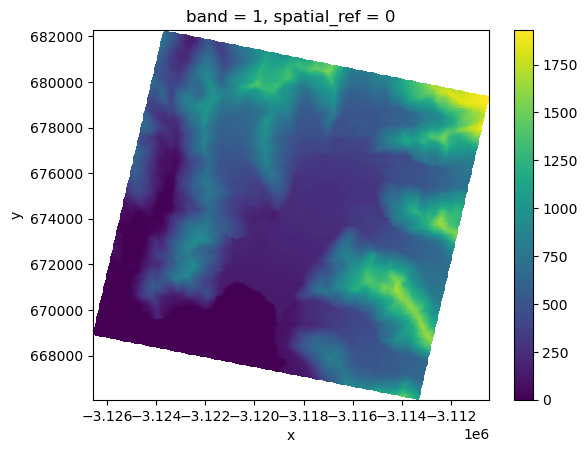

In [33]:
quick_plot_raster(raster=cop30_raster)

### Land Use Raster

As noted earlier, we need a way to identify stable ground locations to achieve a valid coregistration. For this we will use the [10m Annual Land Use Land Cover (9 class) V2](https://planetarycomputer.microsoft.com/dataset/io-lulc-annual-v02) produced by [Impact Observatory](https://www.impactobservatory.com/).

The following cells will preform the same steps as with the reference DEM:

1. Search the STAC catalog for an raster intersecting our AOI
2. Download the selected raster
3. Clip the downloaded raster to our AOI
4. Reproject the clipped raster to the same coordinate system as our strips
5. Visualize the reprojected raster

In [34]:
# Initialize a PCCollectionInfo object for the land use collection
land_info = PCCollectionInfo(
    collection="io-lulc-annual-v02",
    asset_stac_key="data",
    docs_url="https://planetarycomputer.microsoft.com/dataset/io-lulc-annual-v02",
)

In [35]:
# Search the STAC API for intsecting items and show the results interactively
land_items = search_planetary_computer_stac(
    collection=land_info.collection,
    features=aoi,
)
land_items

In [36]:
# Define the index of the asset of interest in the features list
feature_index = 3

# Extract collection name and url to local variables for readability
collection = land_info.collection
url = land_info.get_asset_url(item=land_items[feature_index])

# Define a subdirectory to store background data rasters
BACKGROUND_DIR = DATA_DIR / "background"

# Define the destination path for each raster stage
downloaded_dst = BACKGROUND_DIR / f"{collection}.tif"
clipped_dst = BACKGROUND_DIR / f"{collection}-clipped.tif"
reprojected_dst = BACKGROUND_DIR / f"{collection}-proj.tif"

The following cell downloads the land use raster and may take several seconds to a few minutes to complete depending on your connection.

In [38]:
# Download the source raster
if not downloaded_dst.exists():
    # Only run if the destination raster doesn't already exist
    download_raster(url=url, dst=downloaded_dst)

In [39]:
# Clip the downloaded raster to the project AOI
if not clipped_dst.exists():
    # Only run if the destination raster doesn't already exist
    clip_raster(src=downloaded_dst, dst=clipped_dst, aoi=aoi)

In [40]:
from rasterio.enums import Resampling

# Define the reprojection parameters
dst_epsg = 3413
dst_nodata = 0
resampling_method = Resampling.nearest

# Reproject the clipped raster to the same projection as the strips
if not reprojected_dst.exists():
    # Only run if the destination raster doesn't already exist
    reproject_raster(
        src=clipped_dst,
        dst=reprojected_dst,
        dst_epsg=dst_epsg,
        dst_nodata=dst_nodata,
        resampling_method=resampling_method,
    )

In [41]:
# Store the path to the reprojected raster to a named variable that won't be overwritten
land_raster = reprojected_dst

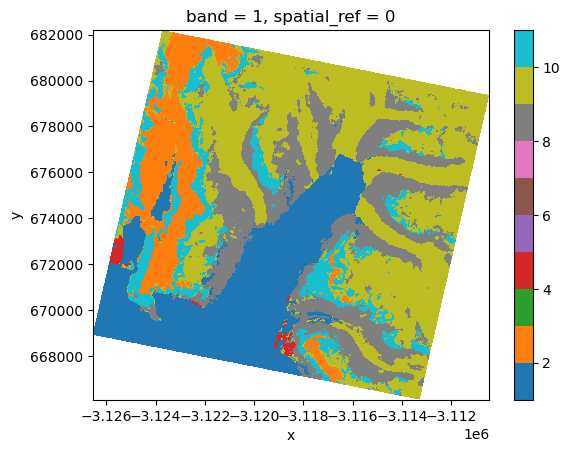

In [42]:
quick_plot_raster(raster=land_raster, cmap="tab10")

## Coregister Strip DEMs

This section will work through the steps for coregistering the strip DEMs utilizing the `xdem` library. 

The steps to complete are:

1. Load the stable ground raster as a mask, resampling to match the pixel size and count of the strip DEMs in the process
2. Load the reference DEM, resampling to match the pixel size and count of the strip DEMs in the process
3. Coregister the 2012 strip DEM to the reference DEM
4. Coregister the 2018 strip DEM to the coregistered 2012 DEM

This portion of the notebook includes many computationally expensive cells. In the event that the Jupyter Kernel crashes, you may restart the kernel and begin executing cells below without rerunning those above. The following cell redefines path constants from early in the notebook to allow for restarting from here.

In [43]:
from pathlib import Path

# Define some path constants for use later in the exercise
NOTEBOOK_DIR = Path(__name__).resolve().parent
DATA_DIR = NOTEBOOK_DIR / "data"

#### Stable Ground Mask

To create a stable ground mask from the land use raster we downloaded above, we will extract out only the cells that correspond to bare ground (cell value 8 in this case).

Additionally, the `xdem` library requires all of the arrays that it operates on to have the same cell size and shape (number of rows and columns). So after the bare ground is extracted, we will upsample the resolution of the raster to match the strip DEMs.

In [44]:
from pathlib import Path
import rioxarray


def extract_stable_ground_raster(src: Path, dst: Path, include_value: int) -> Path:
    """Creates a copy of the source raster, keeping only the cell values that match the provided include value.
    All other cell values will be assigned to NoData."""

    # Load the raster to extract values from
    xds = rioxarray.open_rasterio(filename=src)

    # Filter out cells equal to the excluded value
    xds = xds.where(xds == include_value)

    # Write the extracted raster to the filesystem, making sure the destination
    # directory exists beforehand.
    if not dst.parent.exists():
        dst.parent.mkdir(parents=True)
    xds.rio.to_raster(dst)

    # Return the path to the extracted raster
    return dst

In [45]:
import geoutils

# Define a path to one of the strip DEMs to use as a reprojection reference
DEM_2012_PATH = DATA_DIR / "strips/2012-08-13.tif"

# Define paths for the source land use raster and the destination stable ground raster
LAND_REF_PATH = DATA_DIR / "background/io-lulc-annual-v02-proj.tif"
STABLE_GROUND_PATH = DATA_DIR / "background/io-lulc-annual-v02-proj-stable.tif"

extract_stable_ground_raster(src=LAND_REF_PATH, dst=STABLE_GROUND_PATH, include_value=8)


# Load the stable ground raster as a Mask
stable_ground_mask = geoutils.Mask(STABLE_GROUND_PATH).reproject(
    dst_ref=str(DEM_2012_PATH), src_nodata=0
)

#### Reference DEM

Like the stable ground mask above, we need to upsample the reference DEM to the resolution and shape of the strip DEMs.

In [46]:
import xdem


def prepare_reference_dem_for_coregistration(src: Path, dst: Path, strip: Path) -> Path:
    """Upsamples the reference DEM to the same resolution and cell count as the provided strip."""

    # The strip will serve as the metadata reference to inform the upsampling
    dem_strip = xdem.DEM(filename_or_dataset=strip, vcrs="WGS84")

    # Load the reference DEM, at its original resolution
    dem_ref = xdem.DEM(filename_or_dataset=src, vcrs="EGM08")

    # Many xdem functions require that all rasters have the same shape (row & column count)
    # We can upsample the reference DEM using the strips as a reference
    dem_ref = dem_ref.reproject(dst_ref=dem_strip)

    # The vertical reference may not have survived the reprojection so we will check
    # and reset it if necessary
    if not dem_ref.vcrs:
        dem_ref.set_vcrs("EGM08")

    # Write the raster to the filesystem, making sure the destination
    # directory exists beforehand.
    if not dst.parent.exists():
        dst.parent.mkdir(parents=True)
    dem_ref.save(filename=dst)

    return dst

In [47]:
# Define a path to one of the strip DEMs to use as a reprojection reference
DEM_2012_PATH = DATA_DIR / "strips/2012-08-13.tif"

# Define paths for the source land use raster and the destination stable ground raster
DEM_REF_PROJ_PATH = DATA_DIR / "background/cop-dem-glo-30-proj.tif"
DEM_REF_COREG_READY_PATH = DATA_DIR / "background/cop-dem-glo-30-coreg-ready.tif"

# Prepare the reference DEM for coregistration
if not DEM_REF_COREG_READY_PATH.exists():
    prepare_reference_dem_for_coregistration(
        src=DEM_REF_PROJ_PATH, dst=DEM_REF_COREG_READY_PATH, strip=DEM_2012_PATH
    )

# Load the prepared reference DEM
dem_ref = xdem.DEM(filename_or_dataset=DEM_REF_COREG_READY_PATH, vcrs="EGM08")

In [48]:
import geoutils
import xdem
import matplotlib.pyplot as plt


def plot_backgound_data(
    stable_ground_mask: geoutils.Mask, dem_ref: xdem.DEM
) -> plt.Figure:
    fig, axes = plt.subplots(
        figsize=(15, 5), nrows=1, ncols=3, sharex=True, sharey=True
    )

    ax = axes[0]
    ax.set_title("Stable Ground Mask")
    stable_ground_mask.show(ax=ax, cmap="binary_r", add_cbar=False)

    ax = axes[1]
    ax.set_title("Reference DEM Hillshade")
    xdem.terrain.hillshade(dem=dem_ref).show(ax=ax, cmap="Greys_r", add_cbar=False)

    ax = axes[2]
    ax.set_title("Stable Ground Mask Over Hillshade")
    xdem.terrain.hillshade(dem=dem_ref).show(ax=ax, cmap="Greys_r", add_cbar=False)
    stable_ground_mask.show(ax=ax, cmap="Reds_r", add_cbar=False, alpha=0.5)

    return fig

Let's visualize the background data.

Notice how parts of the "stable ground" overlap some of the glacier covered regions of the DEM. Keep this in mind when we look at the results of the DEM coregistration/differencing.

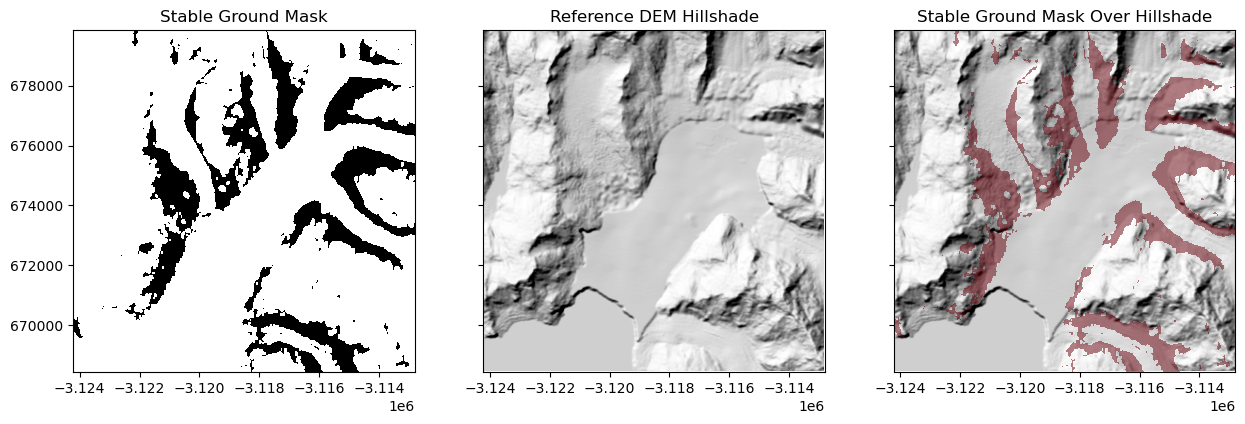

In [49]:
_ = plot_backgound_data(stable_ground_mask=stable_ground_mask, dem_ref=dem_ref)

#### Strip DEMs

Now it is finally time to coregister the strip DEMs. Like the background data, first we must prepare the DEMs for coregistration. In this case, we are going to apply a vertical transformation to get the strip DEMs using the same vertical datum as the reference DEM.

We will coregister the 2012 strip DEM to the reference DEM first. Then we will coregister the 2018 strip DEM to the coregistered 2012 strip DEM. The changes to the 

In [50]:
import xdem


def prepare_strip_dem_for_coregistration(src: Path, dst: Path) -> Path:
    """Applies a vertical transformation to covert the strip from WSG84 to EGM08"""

    # Load the strip DEM, specifying the vertical reference system
    dem_strip = xdem.DEM(filename_or_dataset=src, vcrs="WGS84")

    # Preform a vertical reference transformation from Ellipsoid (WGS84)
    # to Earth Gravity Model 2008 (EGM08)
    dem_strip.to_vcrs("EGM08")

    # Write the raster to the filesystem, making sure the destination
    # directory exists beforehand.
    if not dst.parent.exists():
        dst.parent.mkdir(parents=True)
    dem_strip.save(filename=dst)

    return dst

In [51]:
import geoutils
import xdem


def coregister_dem(
    reference_dem: xdem.DEM, dem_to_be_aligned: xdem.DEM, inlier_mask: geoutils.Mask
) -> xdem.DEM:
    coreg_pipeline = xdem.coreg.NuthKaab()

    coreg_pipeline = coreg_pipeline.fit(reference_dem, dem_to_be_aligned, inlier_mask)

    return coreg_pipeline.apply(dem=dem_to_be_aligned)

In [52]:
import xdem
import matplotlib.pyplot as plt


def plot_dems_side_by_side(
    right_dem: xdem.DEM,
    right_title: str,
    middle_dem: xdem.DEM,
    middle_title: str,
    left_dem: xdem.DEM,
    left_title: str,
) -> plt.Figure:
    plt.close("all")
    fig, axes = plt.subplots(
        figsize=(15, 6.5), ncols=3, nrows=1, sharex=True, sharey=True
    )

    ax = axes[0]
    ax.set_title(right_title)
    right_dem.show(ax=ax)
    xdem.terrain.hillshade(dem=right_dem).show(
        ax=ax, cmap="Greys_r", alpha=0.5, add_cbar=False
    )

    ax = axes[1]
    ax.set_title(middle_title)
    middle_dem.show(ax=ax)
    xdem.terrain.hillshade(dem=middle_dem).show(
        ax=ax, cmap="Greys_r", alpha=0.5, add_cbar=False
    )

    ax = axes[2]
    ax.set_title(left_title)
    left_dem.show(ax=ax)
    xdem.terrain.hillshade(dem=left_dem).show(
        ax=ax, cmap="Greys_r", alpha=0.5, add_cbar=False
    )

    return fig

In [53]:
import xdem
import matplotlib.pyplot as plt


def plot_coregistration_change(
    right_dem: xdem.DEM,
    right_title: str,
    middle_dem: xdem.DEM,
    middle_title: str,
    left_dem: xdem.DEM,
    left_title: str,
    left_vrange: float,
) -> plt.Figure:
    plt.close("all")
    fig, axes = plt.subplots(
        figsize=(15, 6.5), ncols=3, nrows=1, sharex=True, sharey=True
    )

    # Pre-coregistration
    ax = axes[0]
    ax.set_title(right_title)
    right_dem.show(ax=ax)
    xdem.terrain.hillshade(dem=right_dem).show(
        ax=ax, cmap="Greys_r", alpha=0.5, add_cbar=False
    )

    # Coregistered
    ax = axes[1]
    ax.set_title(middle_title)
    middle_dem.show(ax=ax)
    xdem.terrain.hillshade(dem=middle_dem).show(
        ax=ax, cmap="Greys_r", alpha=0.5, add_cbar=False
    )

    # Difference
    ax = axes[2]
    ax.set_title(left_title)
    left_dem.show(ax=ax, cmap="coolwarm_r", vmax=0 + left_vrange, vmin=0 - left_vrange)

    return fig

#### Coregister the 2012 strip DEM

The following cells preform the coregistion and visualization of the 2012 strip DEM. These may take several seconds to complete.

In [54]:
import xdem

DEM_2012_PATH = DATA_DIR / "strips/2012-08-13.tif"
DEM_2012_COREG_READY_PATH = DATA_DIR / "strips/2012-08-13-coreg-ready.tif"

# Prepare the 2012 strip for coregistration
# This may take several seconds
if not DEM_2012_COREG_READY_PATH.exists():
    prepare_strip_dem_for_coregistration(
        src=DEM_2012_PATH, dst=DEM_2012_COREG_READY_PATH
    )

# Load the pre-coregistration strip DEM from the filesystem
dem_2012 = xdem.DEM(filename_or_dataset=DEM_2012_COREG_READY_PATH, vcrs="EGM08")

In [55]:
DEM_2012_COREG_PATH = DATA_DIR / "strips/2012-08-13-coreg.tif"

# Coregister the strip DEM and save it to the file system
if not DEM_2012_COREG_PATH.exists():
    dem_2012_coreg = coregister_dem(
        reference_dem=dem_ref,
        dem_to_be_aligned=dem_2012,
        inlier_mask=stable_ground_mask,
    )
    dem_2012_coreg.save(DEM_2012_COREG_PATH)

# Load the coregistered strip DEM from the filesystem
dem_2012_coreg = xdem.DEM(filename_or_dataset=DEM_2012_COREG_PATH, vcrs="EGM08")

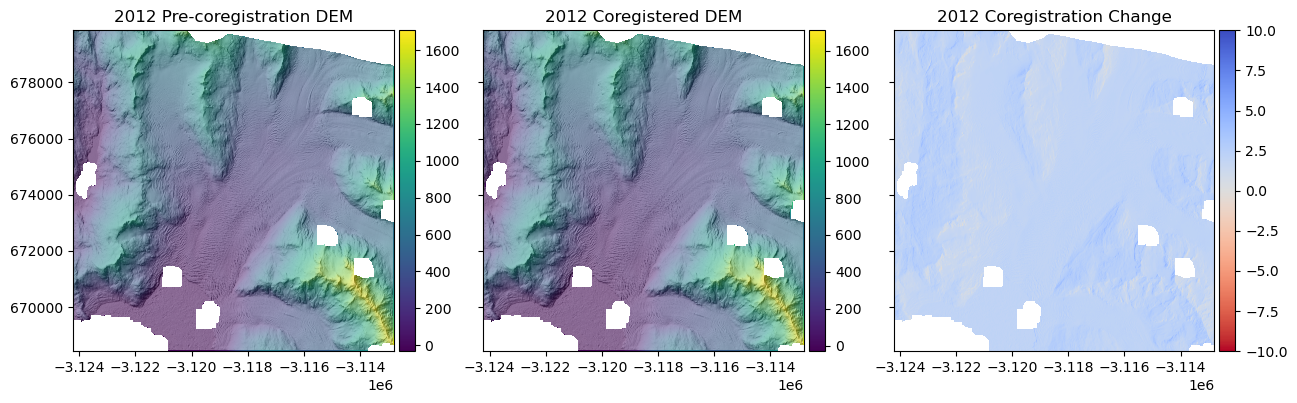

In [56]:
# View the change that the coregistration had on the strip DEM
_ = plot_coregistration_change(
    right_dem=dem_2012,
    right_title="2012 Pre-coregistration DEM",
    middle_dem=dem_2012_coreg,
    middle_title="2012 Coregistered DEM",
    left_dem=dem_2012_coreg - dem_2012,
    left_title="2012 Coregistration Change",
    left_vrange=10,
)

#### Coregister the 2018 strip DEM

The following cells preform the coregistion and visualization of the 2018 strip DEM. These may take several seconds to complete.

In [57]:
import xdem

DEM_2018_PATH = DATA_DIR / "strips/2018-04-16.tif"
DEM_2018_COREG_READY_PATH = DATA_DIR / "strips/2018-04-16-coreg-ready.tif"

# Prepare the 2012 strip for coregistration
# This may take several seconds
if not DEM_2018_COREG_READY_PATH.exists():
    prepare_strip_dem_for_coregistration(
        src=DEM_2018_PATH, dst=DEM_2018_COREG_READY_PATH
    )

# Load the pre-coregistration strip DEM from the file system
dem_2018 = xdem.DEM(filename_or_dataset=DEM_2018_COREG_READY_PATH, vcrs="EGM08")

In [58]:
DEM_2018_COREG_PATH = DATA_DIR / "strips/2018-04-16-coreg.tif"

if not DEM_2018_COREG_PATH.exists():
    dem_2018_coreg = coregister_dem(
        reference_dem=dem_2012_coreg,
        dem_to_be_aligned=dem_2018,
        inlier_mask=stable_ground_mask,
    )
    dem_2018_coreg.save(DEM_2018_COREG_PATH)

# Load the coregistered strip DEM from the filesystem
dem_2018_coreg = xdem.DEM(DEM_2018_COREG_PATH)

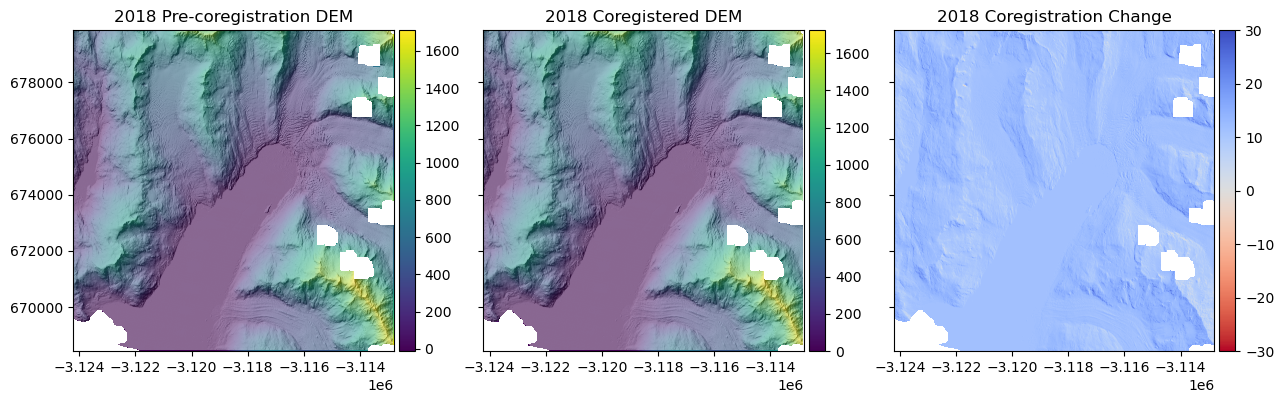

In [59]:
# View the change that the coregistration had on the strip DEM
_ = plot_coregistration_change(
    right_dem=dem_2018,
    right_title="2018 Pre-coregistration DEM",
    middle_dem=dem_2018_coreg,
    middle_title="2018 Coregistered DEM",
    left_dem=dem_2018_coreg - dem_2018,
    left_title="2018 Coregistration Change",
    left_vrange=30,
)

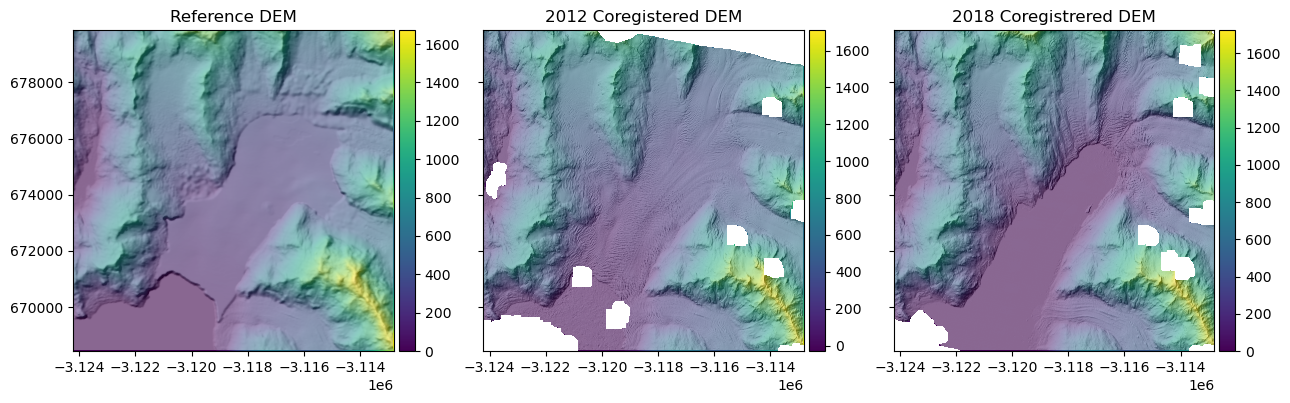

In [60]:
_ = plot_dems_side_by_side(
    right_dem=dem_ref,
    right_title="Reference DEM",
    middle_dem=dem_2012_coreg,
    middle_title="2012 Coregistered DEM",
    left_dem=dem_2018_coreg,
    left_title="2018 Coregistrered DEM",
)

## Visualizing Change with Differencing

Finally, the portion of the notebook that the exercise is named for. The hundreds of lines of code above did all the preparation that makes the rest of the notebook quite simple by comparison. Once we have the DEMs we want to compare loaded into `xdem.DEM` objects, we can simply subtrack one from another to get the change from one date to another.

In [61]:
import xdem

# Differencing is as simple as one DEM minus another
diff: xdem.DEM = dem_2018_coreg - dem_2012_coreg

In [62]:
# We can view stats of the differencing
print(diff.info(stats=True))

Driver:               None 
Opened from file:     None 
Filename:             None 
Loaded?               True 
Modified since load?  True 
Size:                 5717, 5716
Number of bands:      1
Data types:           ('float32',)
Coordinate System:    ['EPSG:3413']
NoData Value:         -9999.0
Pixel Size:           2.0, 2.0
Upper Left Corner:    -3124226.0, 668428.0
Lower Right Corner:   -3112792.0, 679860.0
[MAXIMUM]:          137.90
[MINIMUM]:          -286.21
[MEDIAN]:           6.41
[MEAN]:             -30.34
[STD DEV]:          67.74



In [63]:
import xdem
import matplotlib.pyplot as plt


def plot_dem_diff(dem_1: xdem.DEM, dem_2: xdem.DEM) -> plt.Figure:
    """Create a figure of dem_2 minus dem_1. Show the difference by itself, over a hillshade of dem_1, and over a hillshade of dem_2."""

    diff = dem_2 - dem_1

    vrange = 250
    vmin = 0 - vrange
    vmax = 0 + vrange

    fig, axes = plt.subplots(
        figsize=(15, 5), ncols=3, nrows=1, sharex=True, sharey=True
    )

    ax = axes[0]
    ax.set_title("DEM Difference")
    diff.show(ax=axes[0], cmap="coolwarm_r", vmin=vmin, vmax=vmax)

    ax = axes[1]
    ax.set_title("DEM Difference Over 2012 Hillshade")
    diff.show(ax=ax, cmap="coolwarm_r", vmin=vmin, vmax=vmax)
    xdem.terrain.hillshade(dem=dem_1).show(
        ax=ax, cmap="Greys_r", alpha=0.5, add_cbar=False
    )

    ax = axes[2]
    ax.set_title("DEM Difference Over 2018 Hillshade")
    diff.show(ax=ax, cmap="coolwarm_r", vmin=vmin, vmax=vmax)
    xdem.terrain.hillshade(dem=dem_2).show(
        ax=ax, cmap="Greys_r", alpha=0.5, add_cbar=False
    )

    return fig

Visualize the change in elevation between the coregistered strips. The visualization shows a significant drop in elevation where the glacier has receded. 

Note the blue-gray tint to the rest of the *DEM Difference* figure. This indicates that the surrounding land has increased in elevation, which is not expected.

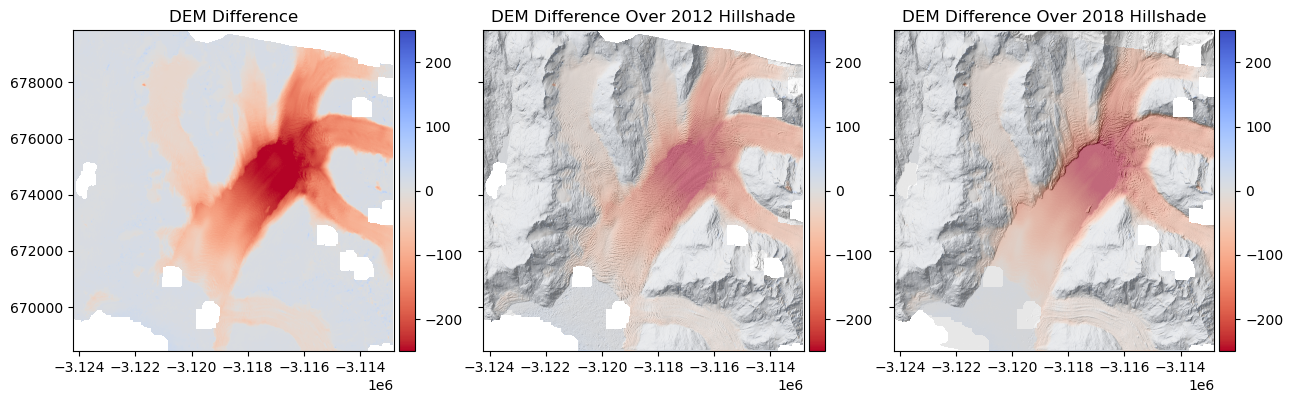

In [64]:
_ = plot_dem_diff(dem_1=dem_2012_coreg, dem_2=dem_2018_coreg)

Below is the same visualization, but with the pre-coregistration DEMs. 

Note that the non-negative portions of the *DEM Difference* figure are more gray (closer to zero) than the previous figure.

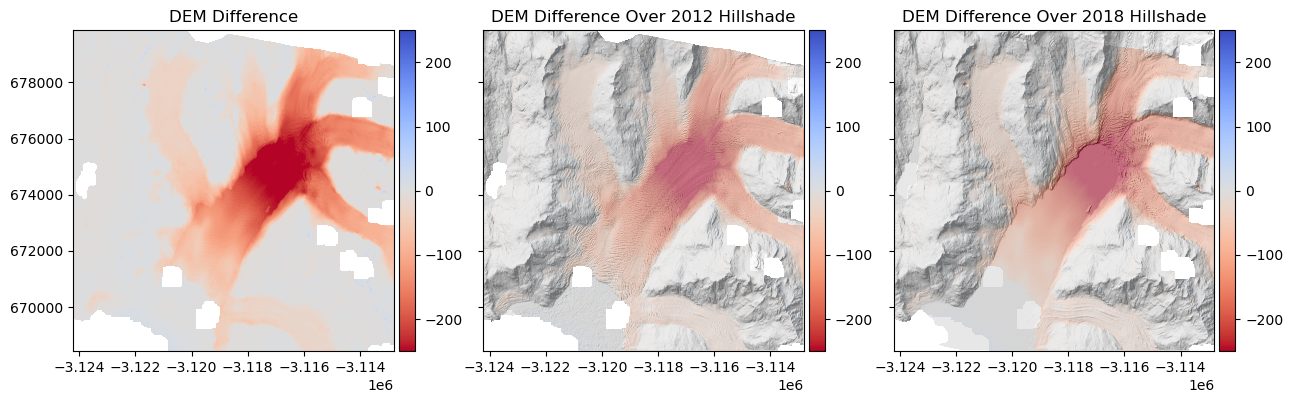

In [65]:
_ = plot_dem_diff(dem_1=dem_2012, dem_2=dem_2018)

In [66]:
import xdem
import matplotlib.pyplot as plt


def plot_binned_diff(dem_1: xdem.DEM, dem_2: xdem.DEM, fig_title: str) -> plt.Figure:
    xds = (dem_2 - dem_1).to_xarray()
    xds = xds.where(xds != dem_1.nodata)
    data = xds[0]

    fig, axes = plt.subplots(
        figsize=(15, 5), nrows=1, ncols=2, sharex=True, sharey=True
    )
    fig.suptitle(fig_title)

    ax = axes[0]
    data.plot.contourf(ax=ax, vmax=0, vmin=-300, cmap="Reds_r", levels=11)
    ax.set_title("Binned decrease in elevation")

    ax = axes[1]
    data.plot.contourf(ax=ax, vmax=30, vmin=0, cmap="Blues", levels=7)
    ax.set_title("Binned increase in elevation")

    return fig

The next two figures take a closer look at the changes by isolating the positive from the negative and binning the changes.

The amount of elevation increase in the coregistered strip DEMs is more apparent. Much of the increase appears to be greater than 10 meters. 

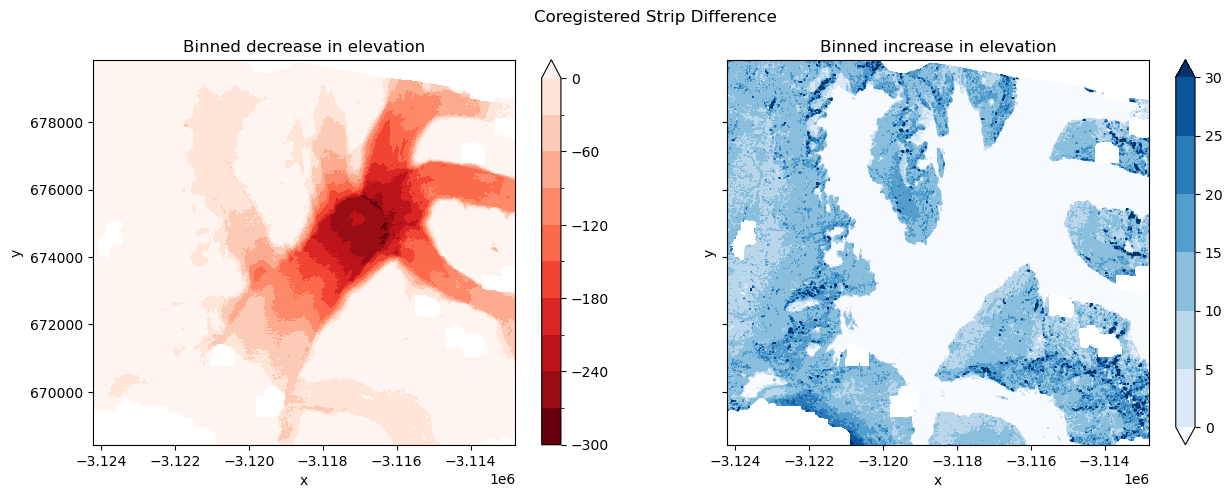

In [67]:
_ = plot_binned_diff(
    dem_1=dem_2012_coreg,
    dem_2=dem_2018_coreg,
    fig_title="Coregistered Strip Difference",
)

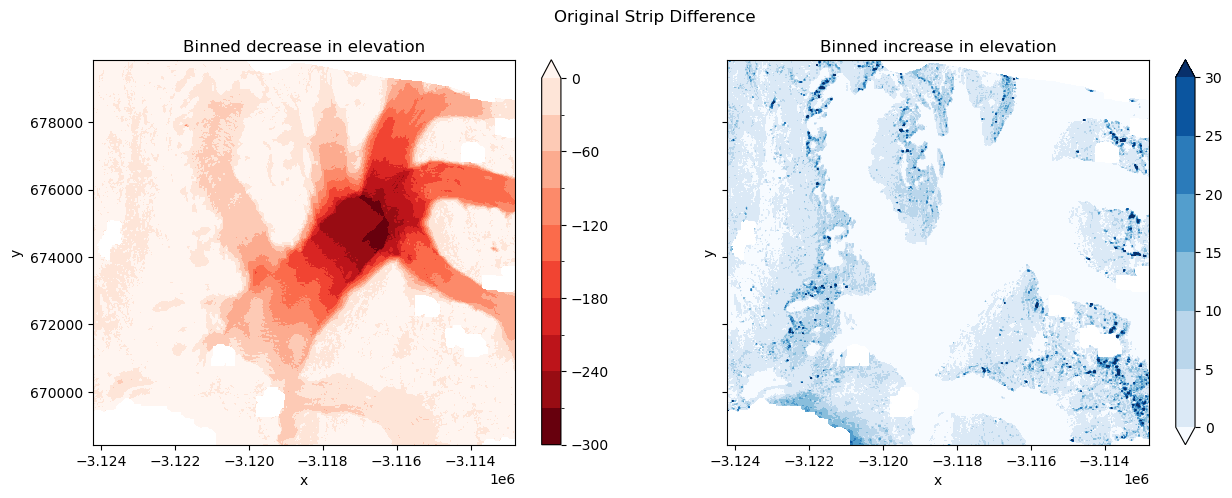

In [68]:
_ = plot_binned_diff(
    dem_1=dem_2012, dem_2=dem_2018, fig_title="Original Strip Difference"
)

So it looks as though the coregistration may have introduced more error than it removed. 

This could be for a number of reasons including, but not limited to:

- An inaccurate stable ground mask
    - Creating a mask from a detailed vector outline of the glacier at each time stamp could improve this.
- A poorly selected coregistration algorithm or combination of algorithms
    - Introducing the [Tilt](https://xdem.readthedocs.io/en/latest/coregistration.html#tilt) correction makes unexpected elevation increases much worse, for instance.
    - The `xdem` library has a [documentation section](https://xdem.readthedocs.io/en/latest/coregistration.html) explaining the use and limitations of the algorithms they provide.

Whatever the reason, let this serve as a reminder that any operation that changes the values of your data (reprojection, coregistration, etc.) should be carefully inspected.